#Практическая работа №1
##Предварительная обработка данных
Выполнила Фонград Анастасия Андреевна КИ21-16/1б Вариант 23
##Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
##Задачи
Выполнение практической работы предполагает решение следующий задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных


In [6]:
import pandas as pd
import numpy as np
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from scipy.stats import sigmaclip
from plot_graph import *

Был произведён импорт данных из .xlsx файла

In [7]:
data = pd.read_excel("C:\\Users\\fongr\\Documents\\Мои документы\\Второй курс\\python\\scientificProject\\data\\first_practice_dataframe.xlsx", sheet_name="Sheet1")
CATEGORICAL = ["cat10_proficiencyLevel", "cat9_age"]
NUMERIC = ["num1_24", "num2_24", "num3_24"]
frame = pd.DataFrame(data[CATEGORICAL + NUMERIC])
print(frame)

    cat10_proficiencyLevel            cat9_age      num1_24      num2_24  \
0                 Advanced      below 21 years   907.348256   242.734013   
1                   Novice  59 years and above   962.219776  1035.400665   
2                   Novice  59 years and above  1053.680910  -469.064161   
3                 Advanced  59 years and above  1148.702980  2793.294228   
4                 Advanced  59 years and above  1018.119147  -954.043533   
..                     ...                 ...          ...          ...   
995               Advanced      below 21 years   815.379375  -154.418945   
996                 novice  59 years and above  1195.478914  -572.061291   
997                 Novice      21 to 35 years   762.115010  -596.334731   
998                 Novice  59 years and above   730.372126 -1101.408593   
999               Advanced      36 to 58 years  1015.521911   838.290002   

        num3_24  
0    971.167308  
1    933.449443  
2    950.209325  
3    942.957073

##Визуальный анализ данных
Были построены несколько видов графиков для каждого из столбцов таблицы

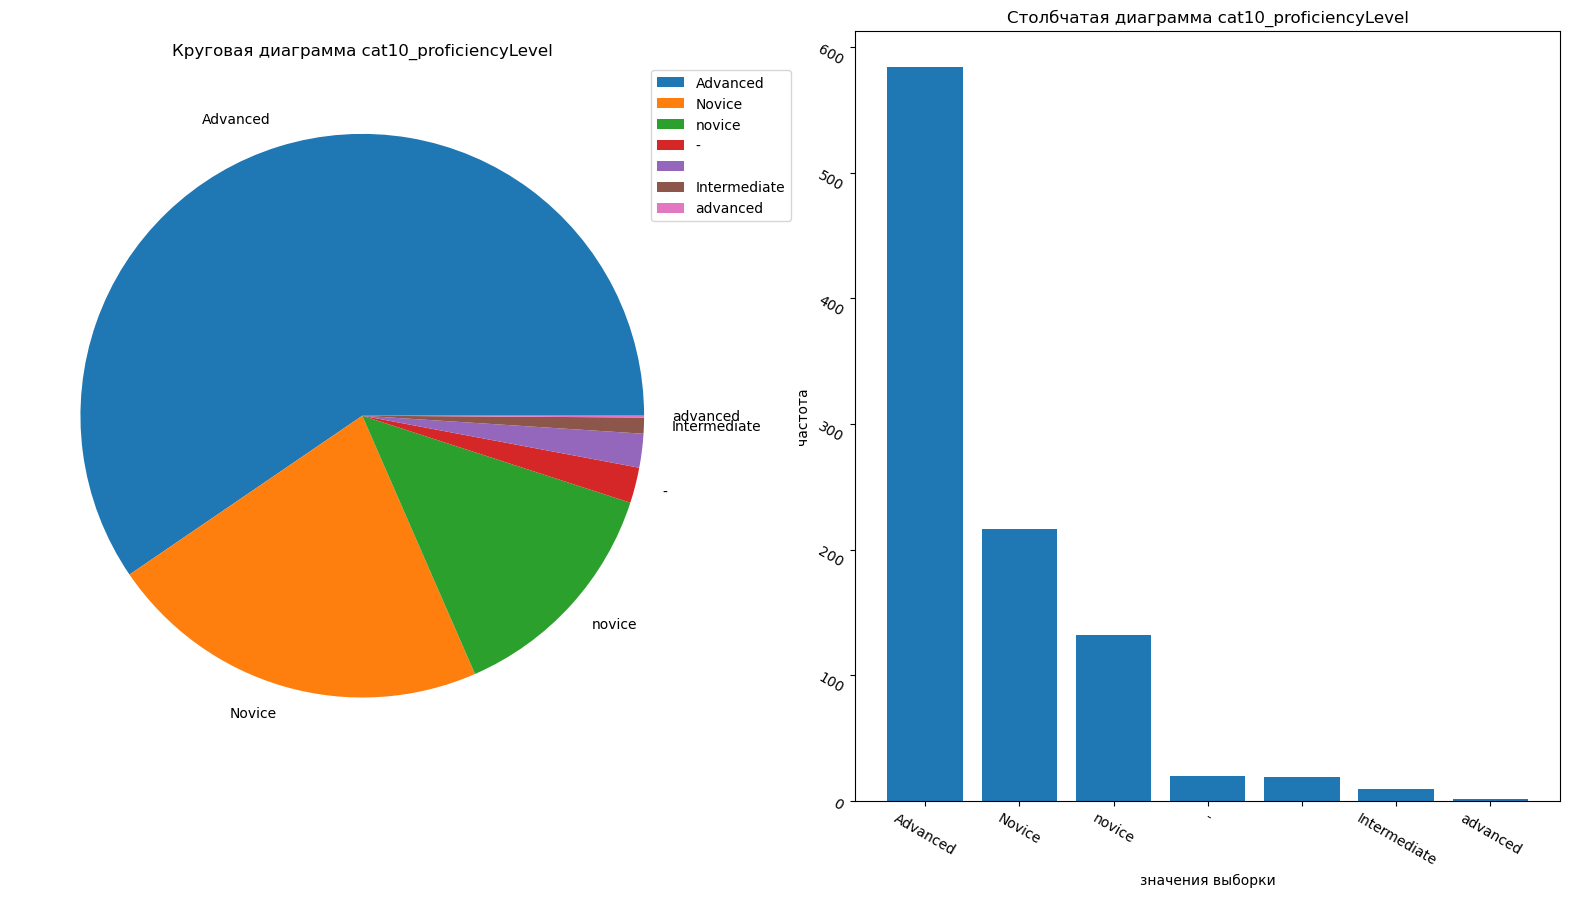

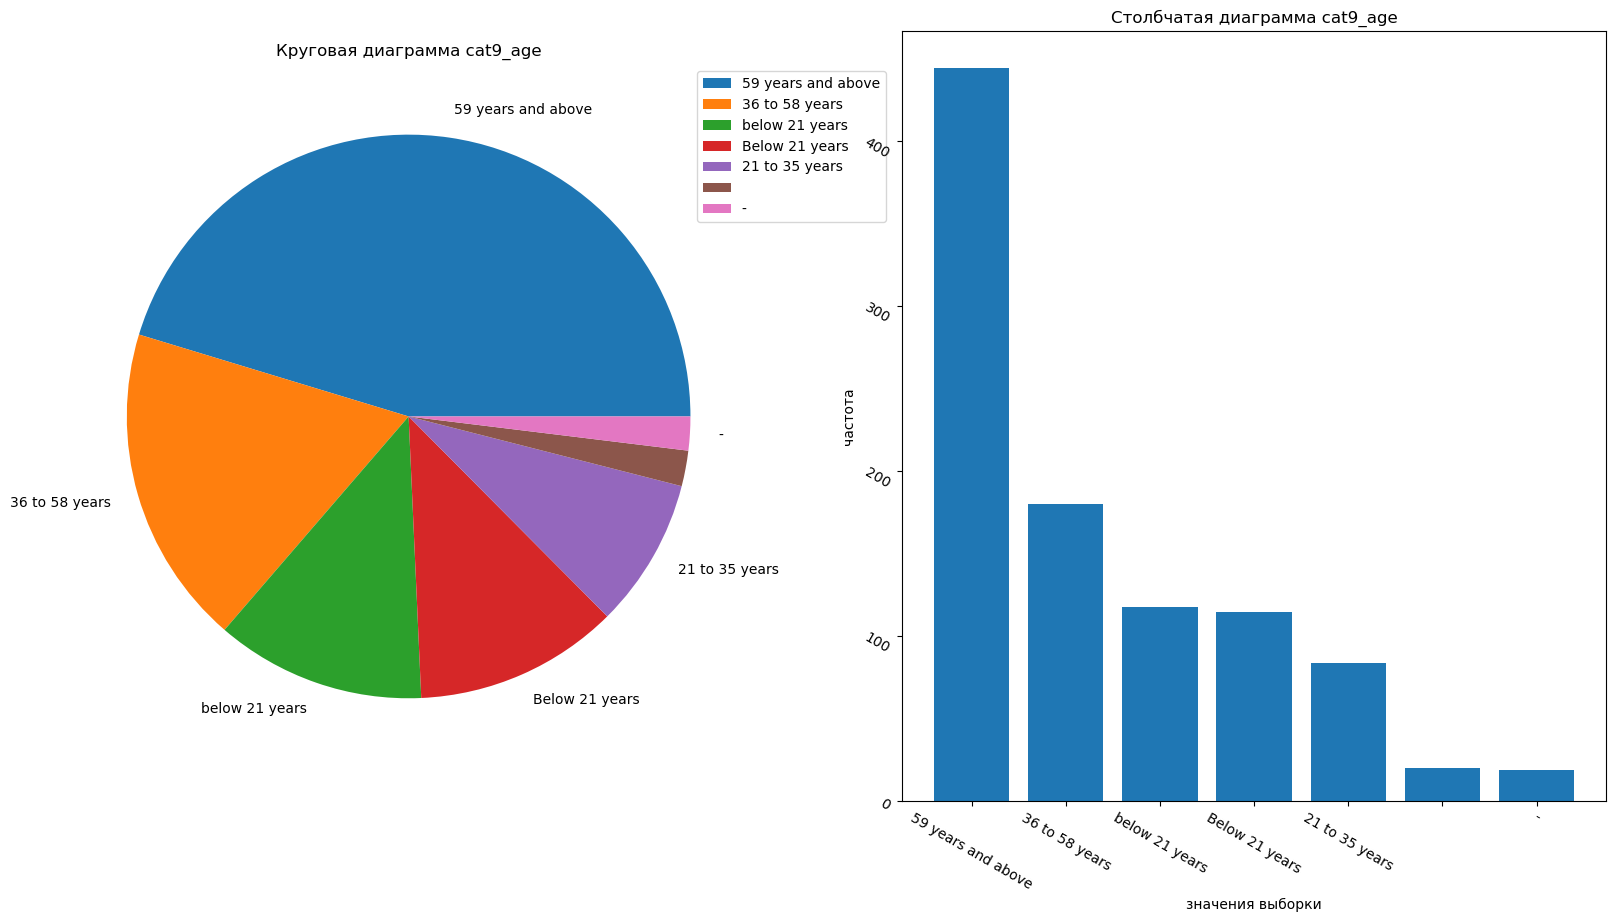

In [8]:
for item in CATEGORICAL:
    build_category_graf(frame, item)

Для построения графиков числовых параметров из них были временно удалены пустые значения. Это позволило избежать ошибок при построении

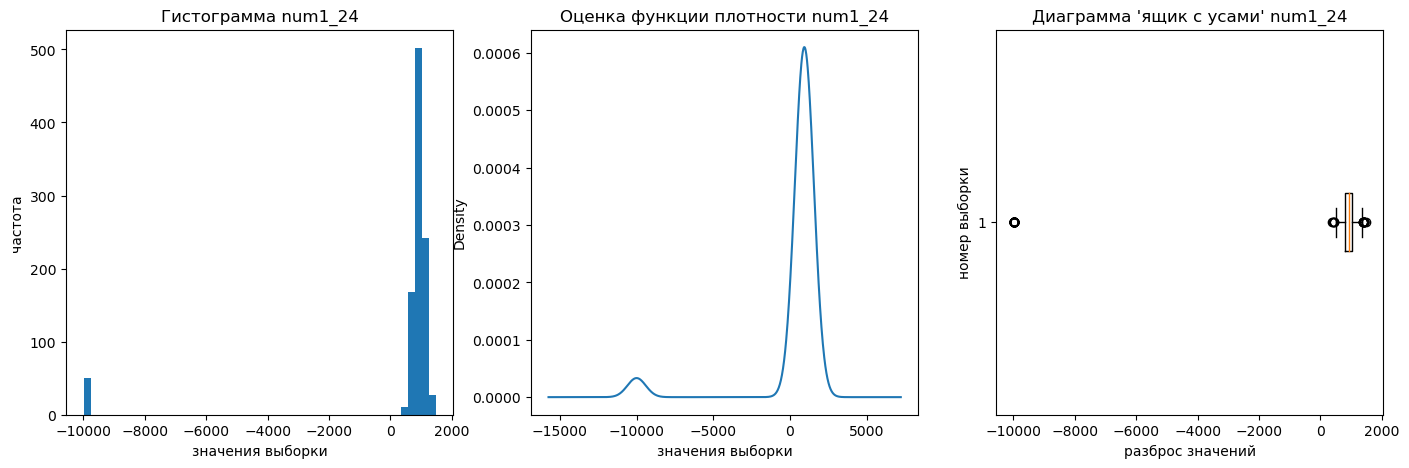

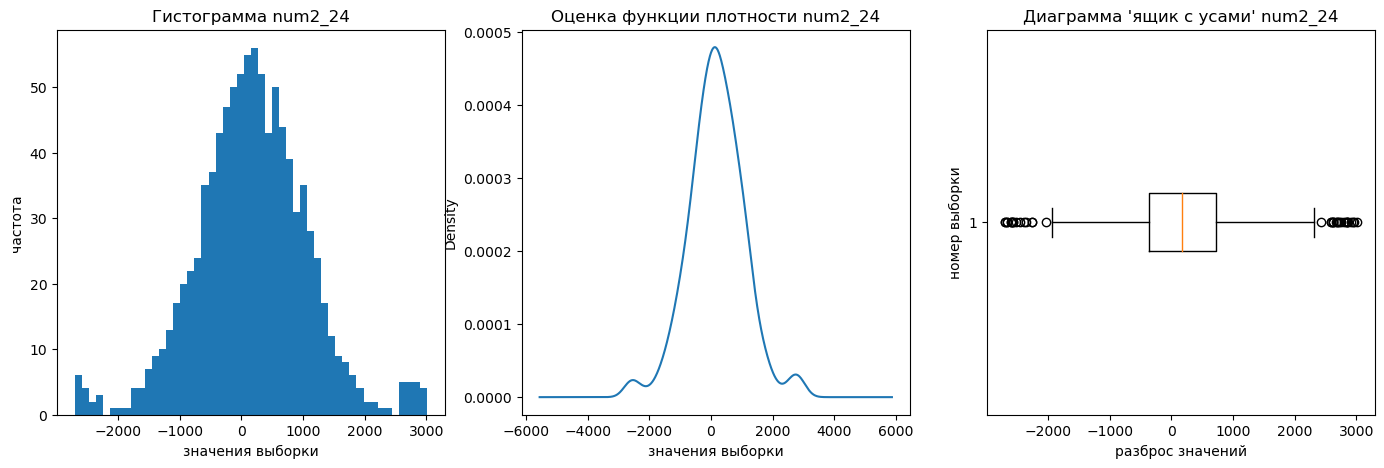

График не может быть построен, т.к. содержит некорректные значения


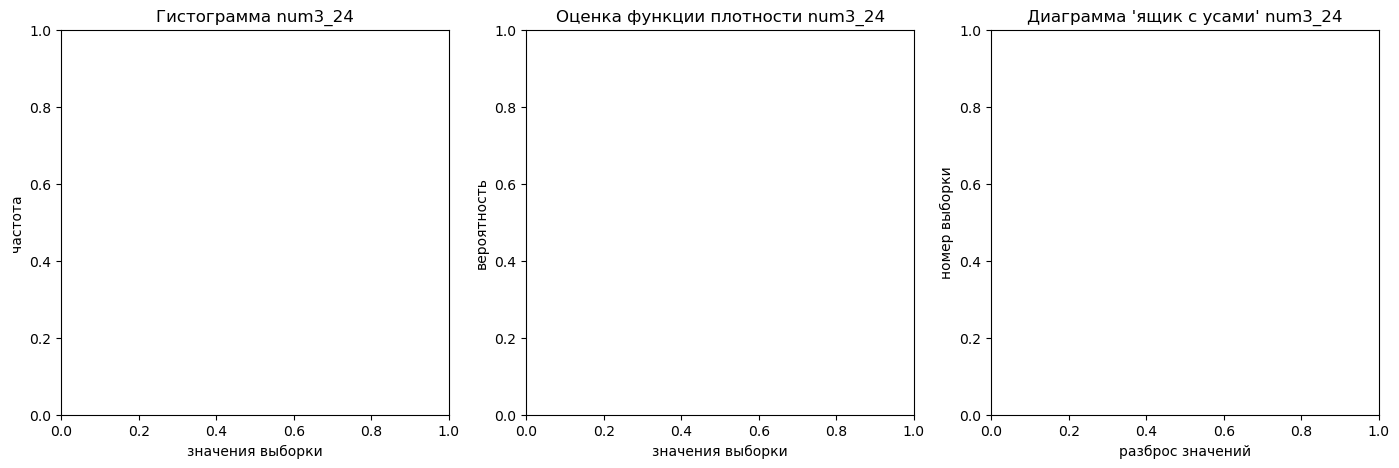

In [9]:
for column in NUMERIC:
    build_numeric_graph(frame, column)

##Поиск аномальных значений
По графикам видно, что некоторые из значений таблицы являются некорректными. Наблюдаются пропуски значений, выбросы, ошибки в именах категорий. Метод info() показывает, что 3 из 5 колонок имеют неверный тип

In [10]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat10_proficiencyLevel  981 non-null    object 
 1   cat9_age                980 non-null    object 
 2   num1_24                 1000 non-null   float64
 3   num2_24                 950 non-null    float64
 4   num3_24                 972 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


###Изменение качественных признаков

Всем пустым значениям был присвоен тип None. Первая буква всех названий категорий была заменена на прописную

In [11]:
for column in CATEGORICAL:
    print(frame[column].value_counts())

Advanced        584
Novice          216
novice          132
-                20
                 19
Intermediate      9
advanced          1
Name: cat10_proficiencyLevel, dtype: int64
59 years and above    444
36 to 58 years        180
below 21 years        118
Below 21 years        115
21 to 35 years         84
                       20
-                      19
Name: cat9_age, dtype: int64


In [12]:
for column in CATEGORICAL:
    frame[column] = frame[column].replace({'-': None, ' ': None, np.NaN: None})
    frame[column] = frame[column].apply(lambda x: x.capitalize() if isinstance(x, str) else None)
    frame[column] = frame[column].astype("category")
    print(frame[column].value_counts())

Advanced        585
Novice          348
Intermediate      9
Name: cat10_proficiencyLevel, dtype: int64
59 years and above    444
Below 21 years        233
36 to 58 years        180
21 to 35 years         84
Name: cat9_age, dtype: int64


Первая и вторая колонки были приведены к категориальному типу

###Изменение количественных признаков
Пустые значения 3 числового признака были заменены на значение NaN.

In [13]:
for column in NUMERIC:
    frame[column] = pd.to_numeric(frame[column], errors='coerce')

Для обновлённого последнего столбца был построен ряд графиков

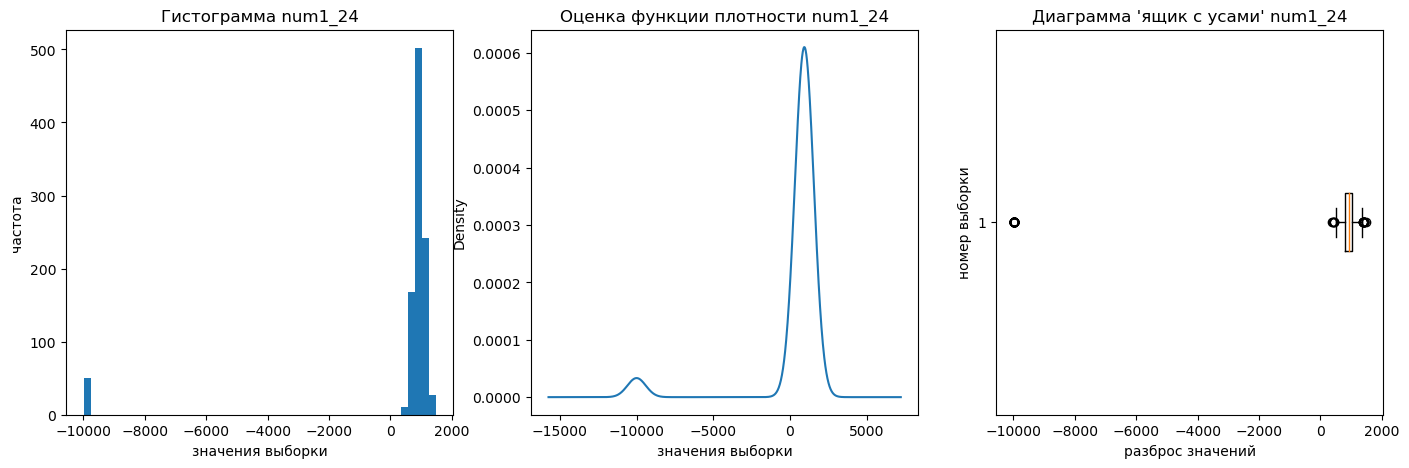

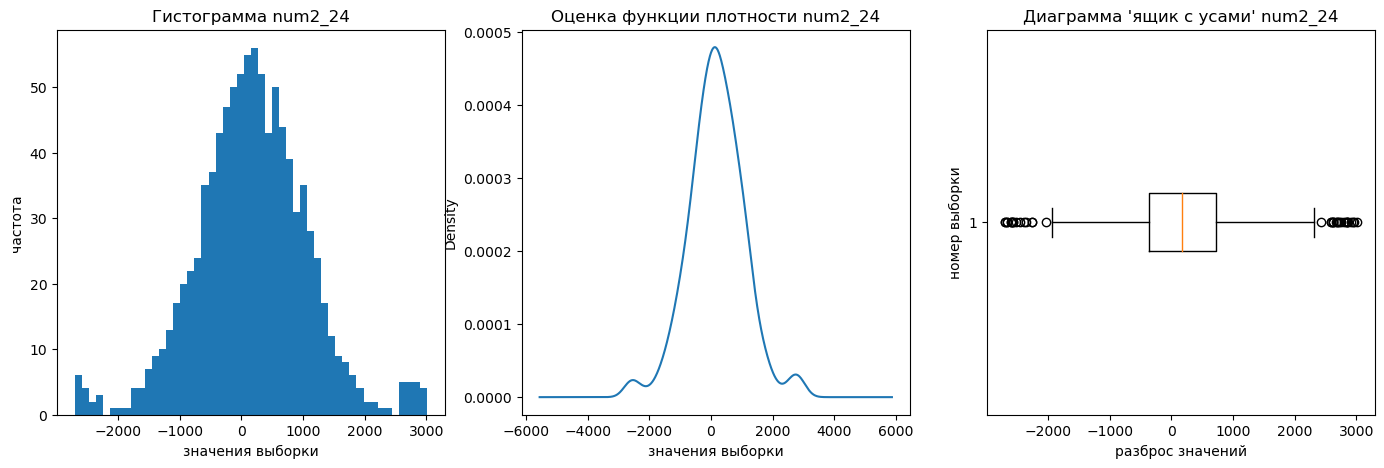

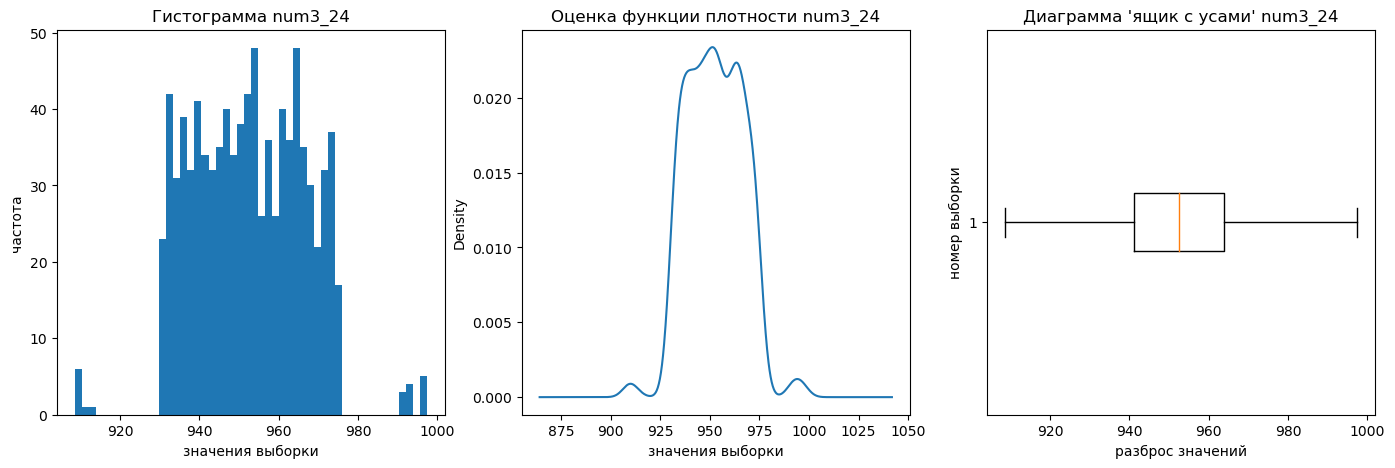

In [14]:
for column in NUMERIC:
    build_numeric_graph(frame, column)

Теперь все качественные признаки имеют тип category, а все количественные - float64

In [15]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cat10_proficiencyLevel  942 non-null    category
 1   cat9_age                941 non-null    category
 2   num1_24                 1000 non-null   float64 
 3   num2_24                 950 non-null    float64 
 4   num3_24                 916 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 25.8 KB


##Поиск и восстановление пропущенных значений
###Метод k ближайших соседей
Пропуски в третьем количественном признаке были заменены на значения, полученные методом ближайших соседей

In [16]:
df_copy = frame.copy()          # копируем датафрейм, чтоб сохранить значение колонок до заполнения
knn_inputer = sklearn.impute.KNNImputer()
inputed_df = knn_inputer.fit_transform(df_copy[[NUM_1, NUM_2, NUM_3]])
frame[NUM_3] = inputed_df[:, 2]
inputed_df

NameError: name 'NUM_1' is not defined

Для устранения пропусков в первом качественном признаке методом k ближайших соседей, их значения были приведены к целочисленным кодам

In [ ]:
frame[PROFICIENCY_LEVEL].value_counts()

Присвоим значениям первого категориального признака числовые коды

In [ ]:
le = LabelEncoder()
frame[PROFICIENCY_LEVEL] = le.fit_transform(frame[PROFICIENCY_LEVEL])
frame[PROFICIENCY_LEVEL].value_counts()

По выводу value_counts видно, что значениям None был присвоен числовой код 3. Вернём их в None и заполним методом k ближайших соседей.

In [ ]:
frame[PROFICIENCY_LEVEL] = frame[PROFICIENCY_LEVEL].replace({3: None})
df_copy = frame.copy()
knn_inputer = sklearn.impute.KNNImputer()
inputed_df = knn_inputer.fit_transform(df_copy[[PROFICIENCY_LEVEL, NUM_1, NUM_2, NUM_3]])
frame[PROFICIENCY_LEVEL] = inputed_df[:, 0]
frame[PROFICIENCY_LEVEL] = frame[PROFICIENCY_LEVEL].apply(
    lambda x: round(x) # Округляем значения до целого числа
)
frame[PROFICIENCY_LEVEL].head(10)

Для обратного кодирования можно воспользоваться методом inverse_transform

In [ ]:
frame[PROFICIENCY_LEVEL] = le.inverse_transform(frame[PROFICIENCY_LEVEL])
frame[PROFICIENCY_LEVEL].value_counts()

Пропуски в 1 и 2 количественных признаках были заполнены средним и медианным значениями соответственно

In [ ]:
median = frame[NUM_2].median()
average = frame[NUM_1].mean()
frame[NUM_1] = frame[NUM_1].fillna(average)
frame[NUM_2] = frame[NUM_2].fillna(median)

Пропуски значений второго признака были заполнены самым популярным значением

In [ ]:
mode = frame[AGE].mode()
frame[AGE] = frame[AGE].fillna(mode)

##Удаление аномальных значений
Были сделаны 3 копии исходного фрейма

In [ ]:
frame_copy = frame.copy()

###Поиск аномальных значений методом сигм
Были найдены выбросы значений для 1 числового параметра. Строки, содержащие выбросы, были удалены из фрейма.

In [22]:
def sigma_method(data_frame, column):
    _, low, high = sigmaclip(data_frame[column], 3, 3) # c < mean(c) - std(c)*low c > mean(c) + std(c)*high (std - стандартное отклонение)
    dropped_values =  data_frame[column][(data_frame[column] < low) | ( data_frame[column] > high)]
    data_frame = data_frame.drop(dropped_values.index)
    return data_frame

In [24]:
frame_sigma = frame.copy()
for column in NUMERIC:
    frame_sigma = sigma_method(frame_sigma, column)
print(f"Число строк после удаления: {len(frame_sigma)}")

Число строк после удаления: 937


C:\Users\fongr\anaconda3\envs\scientificProject\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fongr\anaconda3\envs\scientificProject\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\fongr\anaconda3\envs\scientificProject\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\fongr\anaconda3\envs\scientificProject\lib\site-packages\scipy\stats\_stats_py.py:3435: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
C:\Users\fongr\anaconda3\envs\scientificProject\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


###Поиск аномальных значений методом квантилей

In [17]:
def quantile_method(data_frame, column):
    """
    Вычисляет границу выбросов методом квантилей
    :param data_frame: исходный фрейм данных
    :param column: название колонки для вычисления
    :return: граница начала выбросов
    """
    q25 = data_frame[column].quantile(0.25)
    q75 = data_frame[column].quantile(0.75)
    delta = q75 - q25
    low, high = [(q25 - 1.5 * delta), (q75 + 1.5 * delta)] # Незначительный выброс
    dropped_values =  data_frame[column][(data_frame[column] < low) | ( data_frame[column] > high)]
    data_frame =data_frame.drop(dropped_values.index)
    return data_frame

In [18]:
frame_quantile = frame.copy()
for column in NUMERIC:
    frame_quantile = quantile_method(frame_quantile, column)

Ниже представлены гистограммы колонок очищенного от выбросов распределения, полученного методом сигм и методом квантилей

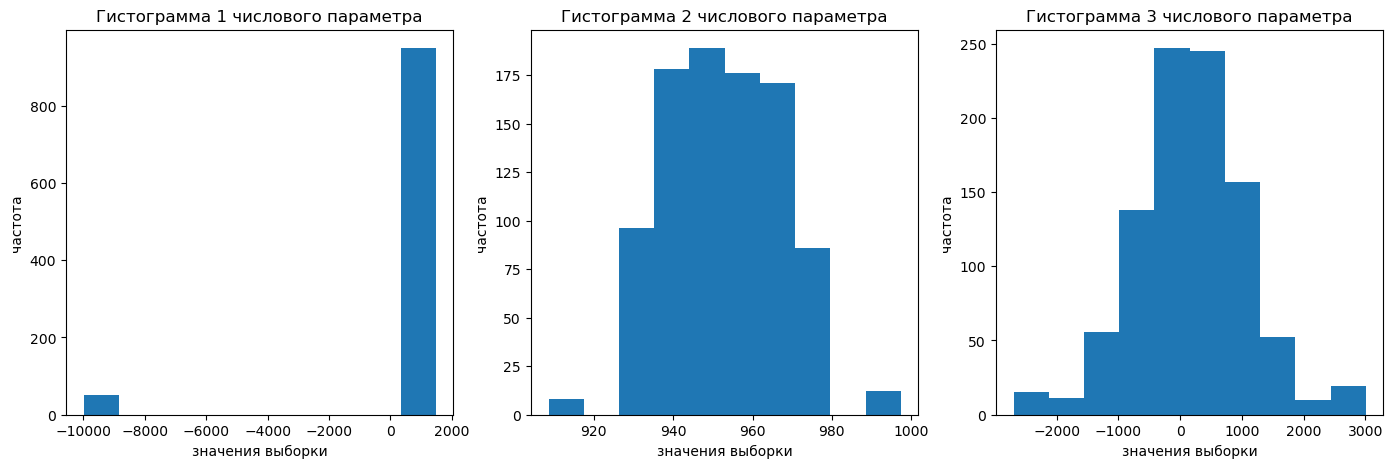

In [21]:
build_three_hists(frame, NUMERIC)

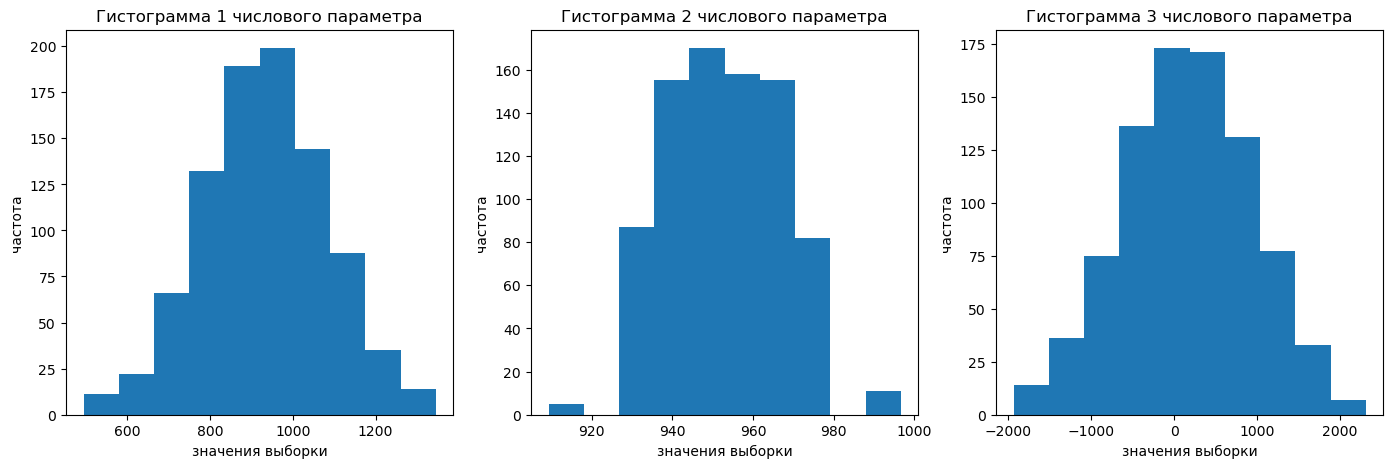

In [20]:
build_three_hists(frame_quantile, NUMERIC)

In [19]:
frame = frame_sigma

NameError: name 'frame_sigma' is not defined

In [ ]:
build_three_hists(frame_quantile, NUM_1, NUM_2, NUM_3)

##Преобразование данных
###Кодировка категориальных признаков
Первый категориальный признак был закодирован с помощью one-hot encoding

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(frame[[PROFICIENCY_LEVEL]]).toarray(), columns=frame[PROFICIENCY_LEVEL].unique())
frame = frame.join(enc_df)
frame.head(10)

Второй категориальный признак был закодирован с помощью label encoding

In [ ]:
frame[AGE + "_num"] = le.fit_transform(frame[AGE])

###Преобразование количественных признаков
Нормализованный набор данных всегда будет иметь значения в диапазоне от 0 до 1.
Стандартизированный набор данных будет иметь среднее значение 0 и стандартное отклонение 1
Первый количественный признак был приведён к нормализованному виду

In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(frame[[NUM_1]])
frame["num_1_scaled"] = scaled_values

Второй и третий количественные признаки были приведены к стандартизованному виду

In [ ]:
scaler_std = StandardScaler()
scaled_values = scaler_std.fit_transform(frame[[NUM_2, NUM_3]])
frame[[NUM_2 + "_scaled", NUM_3 + "_scaled"]] = scaled_values
frame.head(5)

##Выводы
В процессе работы была произведена первичная обработка исходных данных. Было произведено извлечение из фрейма аномальных значений, пропуски в данных были заполнены, все столбцы приведены к стандартизированному виду.
Ниже представлено сравнение исходных и итоговых графиков

In [ ]:
compare_category_graf(data, frame, PROFICIENCY_LEVEL, PROFICIENCY_LEVEL, "уровень мастерства")

In [ ]:
compare_category_graf(data, frame, AGE, AGE, "уровень мастерства")

In [ ]:
data.loc[data[NUM_3]=='-', NUM_3] = float('nan')
data.loc[data[NUM_3]=='', NUM_3] = float('nan')
data.loc[data[NUM_3]==' ', NUM_3] = float('nan')
data[NUM_3] = data[NUM_3].fillna(np.NaN)

In [ ]:
build_numeric_graph(data, NUM_1, "1 до преобразований")

In [ ]:
build_numeric_graph(frame, "num_1_scaled", "1 после преобразований")

In [ ]:
build_numeric_graph(data, NUM_2, "2 до преобразований")

In [ ]:
build_numeric_graph(frame, NUM_2 +"_scaled", "2 после преобразований")

In [ ]:
build_numeric_graph(data, NUM_3, "3 до преобразований")

In [ ]:
build_numeric_graph(frame, NUM_3 +"_scaled", "3 после преобразований")